In [1]:
import matplotlib as mpl

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

import sys
sys.path.append('../../code')

import sparseRRR
from ephys_utils import get_time_voltage_current_currindex0_gouwens
from simulator import EphysModel_Gouwens
from plot_utils import adjust_spines
from rnaseqTools import geneSelection

from openTSNE import TSNE

/Users/yvesbernaerts/Documents/PhD/hh_sbi/hh_sbi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/yvesbernaerts/Documents/PhD/hh_sbi/hh_sbi_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Load observed data
Load the summary statistics of raw membrane voltage recordings generated with `../code/preprocess.ipynb`.

In [2]:
V1_25degree = pickle.load(open('../../code/pickles/V1_features.pickle', 'rb'))
ephys_features = np.array(V1_25degree['X_o'].columns)[:-1]
Xo = V1_25degree['X_o'].copy()
V1_names = V1_25degree['V1_names']

In [4]:
v1_meta = pd.read_csv('../../data/Gouwens (2020)/20200625_patchseq_metadata_mouse.csv')
v1_meta = v1_meta.set_index('ephys_session_id')
v1_meta = v1_meta.reindex(Xo.index.astype('int64'))
celltypes = v1_meta['corresponding_AIT2.3.1_alias']
v1_meta.shape

(4107, 21)

In [5]:
celltype_Vip, celltype_Sst, celltype_Lamp5, celltype_Pvalb, celltype_Sncg, celltype_Serpinf1 = \
    [False]*celltypes.shape[0], [False]*celltypes.shape[0], [False]*celltypes.shape[0], \
        [False]*celltypes.shape[0], [False]*celltypes.shape[0], [False]*celltypes.shape[0]

for i, ct in enumerate(celltypes):
    if isinstance(ct, str):
        if ct.split(' ')[0]=='Vip':
            celltype_Vip[i]=True
        elif ct.split(' ')[0]=='Sst':
            celltype_Sst[i]=True
        elif ct.split(' ')[0]=='Lamp5':
            celltype_Lamp5[i]=True
        elif ct.split(' ')[0]=='Pvalb':
            celltype_Pvalb[i]=True
        elif ct.split(' ')[0]=='Sncg':
            celltype_Sncg[i]=True
        elif ct.split(' ')[0]=='Serpinf1':
            celltype_Serpinf1[i]=True

In [6]:
ephys_features_w_units = np.array(
    [
        "AP threshold (mV)",
        "AP amplitude (mV)",
        "AP width (ms)",
        "AHP (mV)",
        "3rd AP threshold (mV)",
        "3rd AP amplitude (mV)",
        "3rd AP width (ms)",
        "3rd AHP (mV)",
        "AP count",
        "AP count 1st 8th",
        "AP count 1st quarter",
        "AP count 1st half",
        "AP count 2nd half",
        "AP amp adapt",
        "AP average amp adapt",
        "AP CV",
        "ISI adapt",
        "ISI CV",
        "Latency (ms)",
        "rest $V_{m}$ mean (mV)",
        "$V_{m}$ mean (mV)",
        "$V_{m}$ std (mV)",
        "$V_{m}$ skewness",
    ],
    dtype=object,
)

In [7]:
model_param_names = np.array(['C', r'$R_{input}$', r'$\tau$', r'$g_{Nat}$', r'$g_{Na}$', r'$g_{Kd}$', r'$g_{M}$',
                         r'$g_{Kv31}$', r'$g_{L}$', r'$E_{leak}$', r'$\tau_{max}$', 'VT', 'rate_to_SS_factor', 'I'])
prior_min = [0.1,  20,  0.1,    0,        0,      0,      0,      0,      0, -130,    50,    -90,   0.1,   20]
prior_max = [15,   1000,   70,   250,     100,      30,    3,     250,     3,  -50,  4000,   -35,    3,   870]

In [8]:
v1_genes = pd.read_csv('../../data/Gouwens (2020)/20200513_Mouse_PatchSeq_Release_count.csv')
v1_genes=v1_genes.set_index('Unnamed: 0').T
v1_genes=v1_genes.reindex(v1_meta['transcriptomics_sample_id'].values)
gene_names = v1_genes.columns.values
v1_genes.shape

(4107, 45768)

### Figure 8

In [31]:
# load tsne embedding coordinates
Z = np.load("./embedding_coordinates/tsne.npz")["coord"]

We load the gene expression levels again but this time keep the ion channel and marker genes. 

In [9]:
fav_tr_schedule = "2d"

In [10]:
with open(
    "../../code/save_model_parameters/V1/training_schedule_{}.pickle".format(fav_tr_schedule),
    "rb",
) as f:
    THETA = pickle.load(f)
highest_posterior_samples = np.concatenate(
    [
        THETA["highest posterior samples"][cell]
        if cell in THETA["highest posterior samples"]
        else np.ones((13,)) * np.nan
        for cell in Xo.index
    ]
).reshape((Xo.shape[0], len(model_param_names)))

In [11]:
highest_posterior_samples_standardized = (
    highest_posterior_samples - highest_posterior_samples.mean(axis=0)
) / highest_posterior_samples.std(axis=0)

In [12]:
original_gene_names = np.array(v1_genes.columns)
IonChannelGenes = pd.read_csv(
    "../../data/GO_term_summary_20211104_075621.txt", header=0, sep="\t"
)
selectedGenes = np.array(
    [
        (gene in IonChannelGenes["MGI Gene/Marker ID"].values)
        | (
            gene
            in [
                "Pvalb",
                "Lamp5",
                "Vip",
                "Sst",
            ]
        )
        for gene in v1_genes.columns
    ]
)
enough_counts = np.sum(v1_genes, axis=0) >= 10
data_exons = v1_genes.loc[:,selectedGenes & enough_counts]
exonCounts = data_exons.values
gene_names = original_gene_names[selectedGenes & enough_counts]

Further preprocessing for genes (gene selection, library size normalization and Z-scoring)

In [13]:
non_nans = ~np.isnan(exonCounts.sum(axis=1))
exonCounts = exonCounts[non_nans,:]
exonCounts.shape

(3559, 420)

In [14]:
genes = exonCounts.copy()
genes = (
    genes
    / np.sum(genes, axis=1, keepdims=True)
    * np.median(np.sum(genes, axis=1, keepdims=True))
)
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype("float64")

### Sparse reduced-rank regression

In [15]:
M = highest_posterior_samples_standardized[non_nans,:].astype(np.float64)

In [16]:
# alpha tuned to select 25 genes
w, v = sparseRRR.relaxed_elastic_rrr(
    G,
    M,
    rank=2,
    alpha=0.15,
    l1_ratio=1,
)

# save weights
np.savez('./embedding_coordinates/sRRR.npz',
     w=w,
     v=v
    )

In [17]:
sum(w.sum(axis=1)!=0)

25

In [18]:
# genes selected:
print('Genes selected: ', gene_names[w.sum(axis=1)!=0])

Genes selected:  ['Ano4' 'Cacna1e' 'Cacna2d1' 'Cacna2d2' 'Cacna2d3' 'Gabrb2' 'Gabrd'
 'Grid2' 'Itpr1' 'Kcnab3' 'Kcnc2' 'Kcnc4' 'Kcnd3' 'Kcnh7' 'Kcnn3' 'Kcns3'
 'Kcnt2' 'Lamp5' 'Lrrc38' 'Pvalb' 'Scn3b' 'Slc24a4' 'Trpc5' 'Trpm3' 'Vip']


In [19]:
for i in range(len(model_param_names)):
    r2=1-np.sum((M[:,i]-(G@w@v.T)[:,i])**2)/np.sum(M[:,i]**2)
    print(model_param_names[i], ': ', r2)

C :  0.2164888637718354
$R_{input}$ :  0.038145016816265365
$\tau$ :  0.0753195769929268
$g_{Nat}$ :  0.006871402339106769
$g_{Na}$ :  0.0674445422682104
$g_{Kd}$ :  0.17420420925708147
$g_{M}$ :  0.1844303044728388
$g_{Kv31}$ :  0.12374879621079904
$g_{L}$ :  0.0664661550584239
$E_{leak}$ :  0.10187721302614294
$\tau_{max}$ :  0.1616883472610836
VT :  0.04679418350649889
rate_to_SS_factor :  0.33931903152560217
I :  0.04655705548342126


In [20]:
# load sRRR weights
w = np.load("./embedding_coordinates/sRRR.npz")["w"]
v = np.load("./embedding_coordinates/sRRR.npz")["v"]

In [21]:
V1_model=EphysModel_Gouwens(name='V1',
                   T=34.0,
                   E_Na=53.5,
                   E_K=-101.3,
                   E_Ca=131.1,
                   start=100,
                   end=1100,
                   dt=0.04,
                   n_processes=1,
                   noise_factor=10,
                   use_pathos=False,
                   chunk_size=1000,
                   save_chunks=False)

In [22]:
exps_colors = ["darkred", "salmon", "goldenrod", "lightseagreen", "purple", "darkgrey"]

In [23]:
npen_sims = [
    V1_model._run_HH_model(highest_posterior_samples[celltype, :].mean(axis=0))
    for celltype in [
        celltype_Pvalb,
        celltype_Lamp5,
        celltype_Sst,
        celltype_Serpinf1,
        celltype_Vip,
        celltype_Sncg,
    ]
]

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
INFO       Overwriting environment variable "DYLD_LIBRARY_PATH" [brian2.devices.cpp_standalone.device.overwritten_env_var]


In [24]:
npen_xs = np.array([V1_model._calculate_summary_statistics(x)[0] for x in npen_sims])

In [25]:
sRRR_sims = [
    V1_model._run_HH_model(
        ((G @ w @ v.T)[np.array(celltype)[non_nans], :].mean(axis=0))
        * highest_posterior_samples.std(axis=0)
        + highest_posterior_samples.mean(axis=0)
    )
    for celltype in [
        celltype_Pvalb,
        celltype_Lamp5,
        celltype_Sst,
        celltype_Serpinf1,
        celltype_Vip,
        celltype_Sncg,
    ]
]

In [26]:
sRRR_xs = np.array([V1_model._calculate_summary_statistics(x)[0] for x in sRRR_sims])

In [27]:
def create_figure_8(fig):
    if fig is None:
        fig = plt.figure(figsize=(9, 3))
    else:
        fig = fig
    width, height = 0.16, 0.12

    ax_exps = [
        plt.axes([0.15, 0, width, height]),
        plt.axes([0, 0.05, width, height]),
        plt.axes([0.29, 0.22, width, height], zorder=1),
        plt.axes([0, 0.4, width, height]),
        plt.axes([0.02, 0.75, width, height]),
        plt.axes([0.22, 0.66, width, height], zorder=1),
    ]
    ax_sims = [
        plt.axes([0.15, 0.13, width, height]),
        plt.axes([0, 0.18, width, height]),
        plt.axes([0.29, 0.35, width, height]),
        plt.axes([0, 0.53, width, height]),
        plt.axes([0.02, 0.88, width, height]),
        plt.axes([0.22, 0.79, width, height], zorder=1),
    ]
    ax_embed = plt.axes([0.15, 0.3, 0.15, 0.45], zorder=0)
    ax_features = [
        [plt.axes([x, y, 0.07, 0.21]) for y in [0, 0.38, 0.76]]
        for x in [0.48, 0.61, 0.74]
    ]
    return ax_embed, ax_exps, ax_sims, ax_features

In [28]:
features_to_show = [3, 4, 8, 21, 12, 15, 17, 18, 20]

In [29]:
colors=np.array(["grey"]*celltypes.shape[0], dtype=object)
colors[celltype_Lamp5]="salmon"
colors[celltype_Pvalb]="darkred"
colors[celltype_Vip]="purple"
colors[celltype_Sst]="goldenrod"
colors[celltype_Serpinf1]="lightseagreen"
colors[celltype_Sncg]="black"

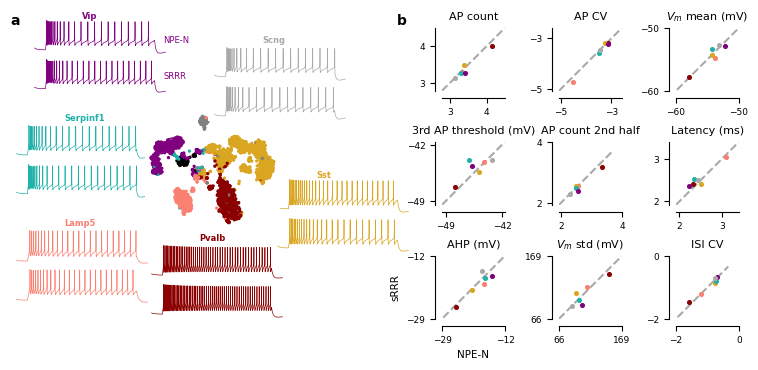

In [32]:
fig = plt.figure(figsize=(9, 3))
ax_embed, ax_exps, ax_sims, ax_features = create_figure_8(fig)
ax_embed.scatter(Z[:, 0], Z[:, 1], s=2, c=colors[non_nans])
ax_embed.set_xticks([])
ax_embed.set_yticks([])
sns.despine(ax=ax_embed, left=True, bottom=True)
for i, ax in enumerate(ax_exps):
    # MAP simulations with NPE-N
    ax.plot(
        npen_sims[i]["time"],
        npen_sims[i]["data"][0, 0, :],
        lw=0.5,
        c=exps_colors[i],
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)

for i, ax in enumerate(ax_sims):
    # sRRR simulation predictions based on genes
    ax.plot(
        sRRR_sims[i]["time"],
        sRRR_sims[i]["data"][0, 0, :],
        lw=0.5,
        c=exps_colors[i],
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)


for i, ax in enumerate(np.array(ax_features).reshape(-1)):
    for j in range(6):
        ax.scatter(
            npen_xs[j, features_to_show[i]],
            sRRR_xs[j, features_to_show[i]],
            color=exps_colors[j],
            s=7,
        )
    std = npen_xs[:, features_to_show[i]].std()
    ax.plot(
        [
            npen_xs[:, features_to_show[i]].min() - 1.1 * std,
            npen_xs[:, features_to_show[i]].max() + 1.1 * std,
        ],
        [
            npen_xs[:, features_to_show[i]].min() - 1.1 * std,
            npen_xs[:, features_to_show[i]].max() + 1.1 * std,
        ],
        "--",
        c="darkgrey",
        zorder=0,
    )
    ax.set_xlim(
        (
            npen_xs[:, features_to_show[i]].min() - 1.1 * std,
            npen_xs[:, features_to_show[i]].max() + 1.1 * std,
        )
    )
    ax.set_ylim(
        (
            npen_xs[:, features_to_show[i]].min() - 1.1 * std,
            npen_xs[:, features_to_show[i]].max() + 1.1 * std,
        )
    )
    ax.set_xticks(
        [
            round(npen_xs[:, features_to_show[i]].min() - 1.1 * std),
            round(npen_xs[:, features_to_show[i]].max() + 1.1 * std),
        ]
    )
    ax.set_yticks(
        [
            round(npen_xs[:, features_to_show[i]].min() - 1.1 * std),
            round(npen_xs[:, features_to_show[i]].max() + 1.1 * std),
        ]
    )
    if i == 0:
        ax.set_xlabel("NPE-N", fontsize=7.5)
        ax.set_ylabel("sRRR", fontsize=7.5)
    ax.tick_params(which="both", labelsize=6.5)
    ax.set_title(ephys_features_w_units[features_to_show[i]], fontsize=8)
    adjust_spines(ax, ["left", "bottom"])
    sns.despine(ax=ax)

fs = 6
fig.text(0.17, 0.92, "NPE-N", fontsize=fs, color="purple")
fig.text(0.17, 0.8, "SRRR", fontsize=fs, color="purple")
fig.text(0.06, 0.31, "Lamp5", fontsize=fs, color="salmon", fontweight="bold")
fig.text(0.28, 0.92, "Scng", fontsize=fs, color="darkgrey", fontweight="bold")
fig.text(0.06, 0.66, "Serpinf1", fontsize=fs, color="lightseagreen", fontweight="bold")
fig.text(0.08, 1, "Vip", fontsize=fs, color="purple", fontweight="bold")
fig.text(0.34, 0.47, "Sst", fontsize=fs, color="goldenrod", fontweight="bold")
fig.text(0.21, 0.26, "Pvalb", fontsize=fs, color="darkred", fontweight="bold")
fig.text(0, 0.98, "a", fontsize=10, color="k", fontweight="bold")
fig.text(0.43, 0.98, "b", fontsize=10, color="k", fontweight="bold")

plt.savefig("figure_8_V1.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_8_V1.png", bbox_inches="tight", pad_inches=0)